In [1]:
import numpy as np
import os, time, json

import os

from FLKutils2 import learn_t, get_logflk_config, plot_data, return_best_chi2dof, plot_ref_data, candidate_sigma
from FLKutils_min import BuildSample_DY, normalize
from scipy.special import logsumexp
from scipy.stats import norm


from matplotlib import pyplot as plt

In [9]:
ref = BuildSample_DY(N_Events=20000, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=0))

DiLepton_SM
(20000, 6)


In [10]:
cut_mll = 60
cut_pt = 20
cut_eta = 2.4

mask_idx = np.where((ref[:, 4] <= cut_pt) | (ref[:, 5] <= cut_pt) | (np.abs(ref[:, 1]) >= cut_eta) | (np.abs(ref[:, 2]) >= cut_eta) | (ref[:, 3] <= cut_mll))[0]
dataset = np.delete(ref, mask_idx, axis=0)

In [11]:
# mean and std of reference data compute from the entire dataset - used to normalize
mean_ref = [3.05212537e+00, 4.59876795e-04, 3.66978211e-04, 4.67488118e+01, 3.60544255e+01]
std_ref = [0.52342366, 1.24487457, 1.25051629, 15.86122412, 8.95046637]

In [12]:
for perc in [1, 5, 25, 50, 75, 95, 99]:
    print(candidate_sigma(normalize(ref[:,[0,1,2,4,5]],mean_ref,std_ref), perc=perc))

0.327
0.593
1.234
1.845
2.536
3.554
4.211


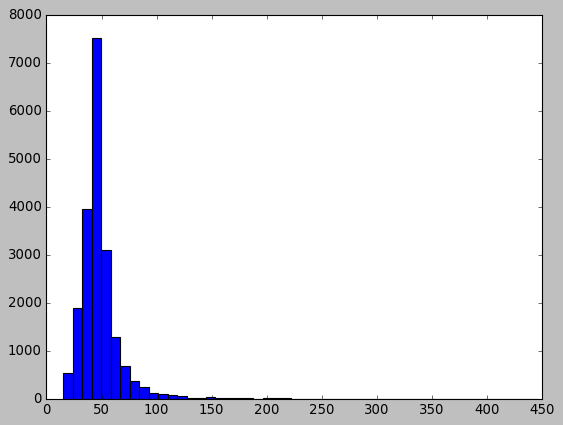

In [11]:
plt.hist(ref[:,4],bins=50)
plt.show()

In [3]:
cut_mll = 100
cut_pt = 20
cut_eta = 2.4

#['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']

mask_idx = np.where((ref[:, 4] <= cut_pt) | (ref[:, 5] <= cut_pt) | (np.abs(ref[:, 1]) >= cut_eta) | (np.abs(ref[:, 2]) >= cut_eta) | (ref[:, 3] <= cut_mll))[0]
masked_ref = np.delete(ref, mask_idx, axis=0)

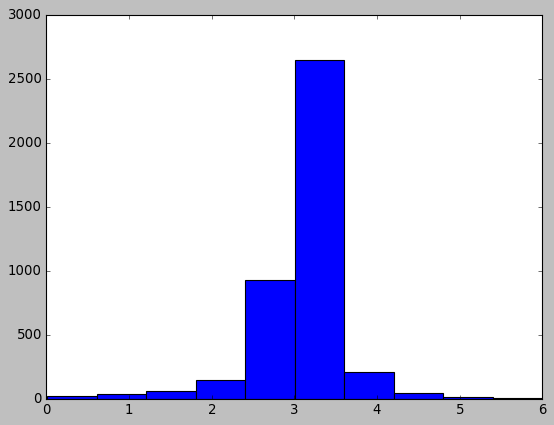

In [5]:
plt.hist(masked_ref[:,0])
plt.show()

## test 

In [2]:
output_path = './output/'


In [3]:
test_ref = np.random.default_rng(seed=0).exponential(scale=1, size=(20000, 1))
print(
    #candidate_sigma(test_ref, perc=10),
    #candidate_sigma(test_ref, perc=25),
    #candidate_sigma(test_ref, perc=50),
    #candidate_sigma(test_ref, perc=90),
    candidate_sigma(test_ref, perc=75),
)

NameError: name 'candidate_sigma' is not defined

In [4]:
# multiple testing definition
flk_sigmas = [0.1, 0.3, 0.7, 1.4, 2.4, 3.0] #10,25,50,75,90,95 percentiles
M          = [5000,5000,5000,5000,5000,5000]
lam        = [1e-10,1e-10,1e-10,1e-10,1e-10,1e-10]
Ntoys      = 300

# initialize 
tstat_dict = {}
seeds_dict = {}
seeds_flk_dict = {}

# problem definition
N_ref      = 20000
N_Bkg      = 2000
N_Sig      = 0
weight    = N_Bkg*1./N_ref
Sig_loc    = 4
Sig_std    = 0.64

In [5]:
if N_Sig: filename = f'Ntoys{Ntoys}_NR{N_ref}_NB{N_Bkg}_NS{N_Sig}_loc{Sig_loc}_std{Sig_std}'
else: filename = f'Ntoys{Ntoys}_NR{N_ref}_NB{N_Bkg}_null'
os.makedirs(output_path+filename, exist_ok = True)

In [6]:
seeds = np.arange(Ntoys)*int(time.time()/1000000)
np.savetxt(output_path+filename+"/seeds.txt",seeds.tolist(),delimiter=",")

In [ ]:
t_dict = {}
for idx, flk_sigma in enumerate(flk_sigmas):
    t_list = [] 
    flk_config = get_logflk_config(M[idx],flk_sigma,[lam[idx]],weight=weight,iter=[1000000],seed=None,cpu=False) # seed for center is re-set inside run_toy

    for i in range(Ntoys):
        seed = seeds[i]
        rng = np.random.default_rng(seed=seed)
        # data
        N_Bkg_Pois  = rng.poisson(lam=N_Bkg, size=1)[0]
        #N_ref_Pois  = rng.poisson(lam=N_ref, size=1)[0]
        #N_observed_ref = N_ref_Pois
        if N_Sig: N_Sig_Pois = rng.poisson(lam=N_Sig, size=1)[0]
        else: N_Sig_Pois = N_Sig
        Ntot = N_Bkg_Pois+N_Sig+N_ref

        dataset = np.zeros(shape=(Ntot,1))

        dataset[:N_Bkg_Pois] = rng.exponential(scale=1, size=(N_Bkg_Pois, 1))
        if N_Sig:
            dataset[N_Bkg_Pois:N_Bkg_Pois+N_Sig_Pois]  = rng.normal(loc=Sig_loc, scale=Sig_std, size=(N_Sig_Pois,1))
        dataset[N_Bkg_Pois+N_Sig_Pois:]  = rng.exponential(scale=1, size=(N_ref, 1))

        # target
        target   = np.zeros_like(dataset)
        target[:N_Bkg_Pois+N_Sig_Pois] = np.ones(shape=(N_Bkg_Pois+N_Sig_Pois,1))
        
        weights = np.ones_like(dataset)
        weights[N_Bkg_Pois+N_Sig_Pois:] = np.full(shape=(N_ref,1),fill_value=weight)
        #weightsData = np.ones_like(featureData)
        #weightsRef  = np.ones_like(featureRef)*weight
        #target      = np.concatenate((targetData, targetRef), axis=0)
        #weights     = np.concatenate((weightsData, weightsRef), axis=0)
        #target      = np.concatenate((target, weights), axis=1)

        # ARRIVATO QUA -- da controllare

        # run
        #if not i%20: plot_reco=True
        #else: plot_reco=False
        plot_reco=False
        st_time = time.time()
        t = learn_t(dataset, target,  weight=weight, seed=seed, flk_config=flk_config)
        dt = round(time.time()-st_time,2)
        print(f"(M,lambda,sigma)={M[idx],lam[idx],flk_sigma}: t={t}, time={dt}.")
        t_list.append(t)
    t_dict[(M[idx],lam[idx],flk_sigma)]=t_list
    #seed[NP][str(flk_sigma)]=np.array(seeds_flk)

In [16]:
t_dict

{(1000, 1e-06, 0.1): [71.5074264085593,
  74.13269086456131,
  71.86519257415219,
  68.75683745606086,
  87.30509768881637],
 (1000, 1e-06, 0.3): [27.412386475117206,
  31.765695231496302,
  16.71336663096048,
  33.34778557506008,
  45.561718751015945],
 (1000, 1e-06, 0.7): [12.15188571569864,
  20.112963067016004,
  8.837418122606,
  13.0166604107015,
  21.051303591499828]}

In [9]:
seeds

array([   0, 1710, 3420, 5130, 6840])

## mmd-fuse metric

In [2]:
ref = np.load("./output/Ntoys1000_NR20000_NB2000_null/t_array.npy")
data = np.load("./output/Ntoys300_NR20000_NB2000_NS10_loc6.4_std0.16//t_array.npy")

In [43]:
def emp_p_value(ref,data):
    #for idx,el in enumerate(t):
    #    p[idx] = np.mean(ref>=t)
    return np.array([np.mean(ref>=t) for t in data])

def p_to_z(pvals):
    return norm.ppf(1 - pvals)

def Zscore(ref,data):
    return p_to_z(emp_p_value(ref,data))


In [44]:
round(np.median(Zscore(ref[:,4],data[:,4])),3)

2.064

In [45]:
def fusion(x,T):
    return T * logsumexp(1/T*x, axis=1, b=1/x.shape[0])

In [46]:
fused_t = fusion(ref,1)
fused_t.shape

(1000,)

In [47]:
def fused_p(ref,data,T):
    fused_ref = fusion(ref,T)
    fused_data = fusion(data,T)

    return emp_p_value(fused_ref,fused_data)

In [8]:
T=1
np.median(Zscore(fusion(ref,T),fusion(data,T)))

1.4796185767461603

In [48]:
T = 1
p_fused = fused_p(ref,data,T)
np.median(p_to_z(p_fused))


1.4796185767461603

In [49]:
def bootstrap_pn(pn,seed=None):
    rnd = np.random.default_rng(seed=seed)
    return rnd.choice(pn,size=len(pn))

def bootstrap_pval(pn,t,seed=None):
    return np.mean(bootstrap_pn(pn,seed=seed)<=t)

In [50]:
def min_p(ref,data):
    # ref: nxd numpy array
    # data: mxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    return np.min(p_ref,axis=1), np.min(p_data,axis=1)

In [51]:
pmin_ref, pmin_data = min_p(ref,data)

In [52]:
len(pmin_ref)-np.count_nonzero(pmin_ref)

1

In [53]:
pvals_min_p_ref = []
for idx, el in enumerate(np.transpose(pmin_ref)):
        pvals_min_p_ref.append(bootstrap_pval(np.delete(pmin_ref,idx),el))
#pvals_ref_min = [bootstrap_pval(np.delete(col,idx),el) for el in col]

In [54]:
pvals_min_p_data = emp_p_value(pmin_ref,pmin_data)

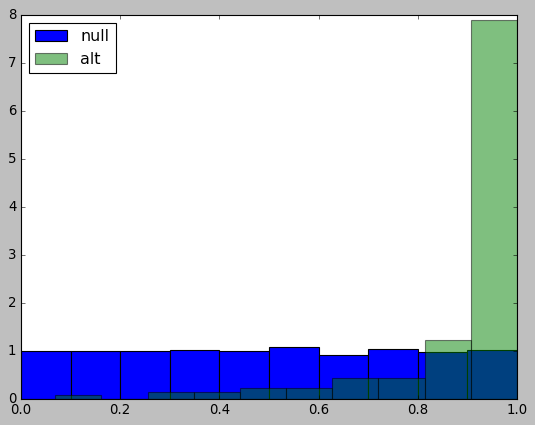

In [55]:
plt.hist(pvals_min_p_ref,bins=10,density=True, label='null')
plt.hist(pvals_min_p_data,bins=10,density=True, alpha=0.5, label='alt')
plt.legend(loc=0)
plt.show()

In [63]:
np.abs(np.median(Zscore(pmin_ref,pmin_data)))

1.9773684281819461

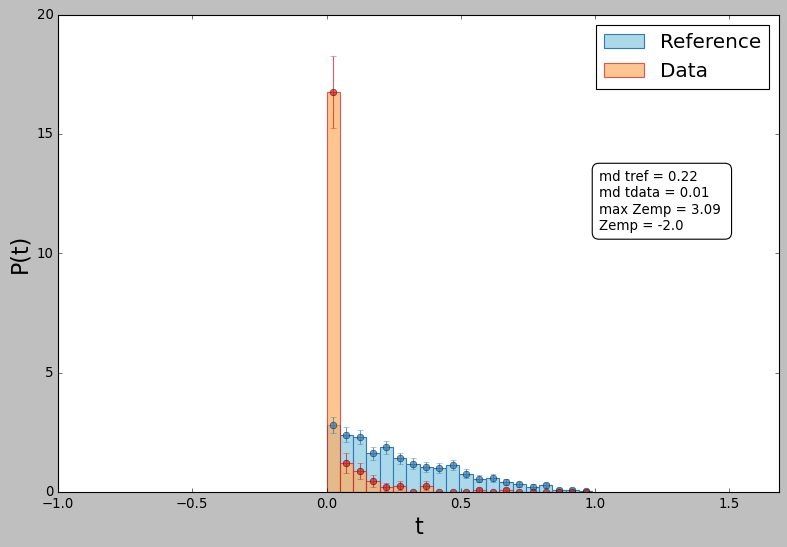

In [153]:
plot_ref_data(pmin_ref,pmin_data,bins=20)

In [71]:
def fused_p(ref,data,T=1):
    # ref: nxd numpy array
    # data: mxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    #return np.min(p_ref,axis=1), np.min(p_data,axis=1)
    return -T * logsumexp(-1/T*p_ref, axis=1, b=1/p_ref.shape[0]), -T * logsumexp(-1/T*p_data, axis=1, b=1/p_data.shape[0])

In [84]:
fused_p_ref, fused_p_data = fused_p(ref,data,0.00001)

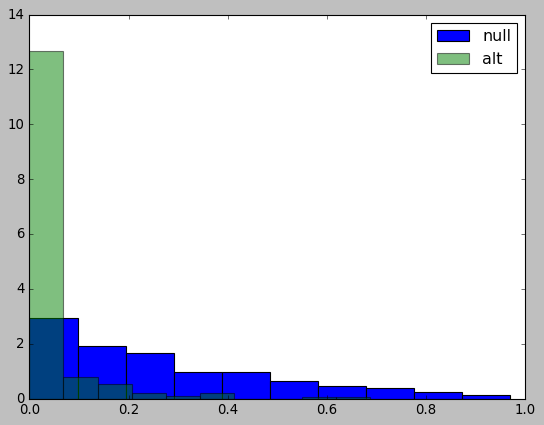

In [85]:
plt.hist(fused_p_ref,bins=10,density=True, label='null')
plt.hist(fused_p_data,bins=10,density=True, alpha=0.5, label='alt')
plt.legend(loc=0)
plt.show()

In [68]:
np.abs(np.median(Zscore(fused_p_ref,fused_p_data)))

inf

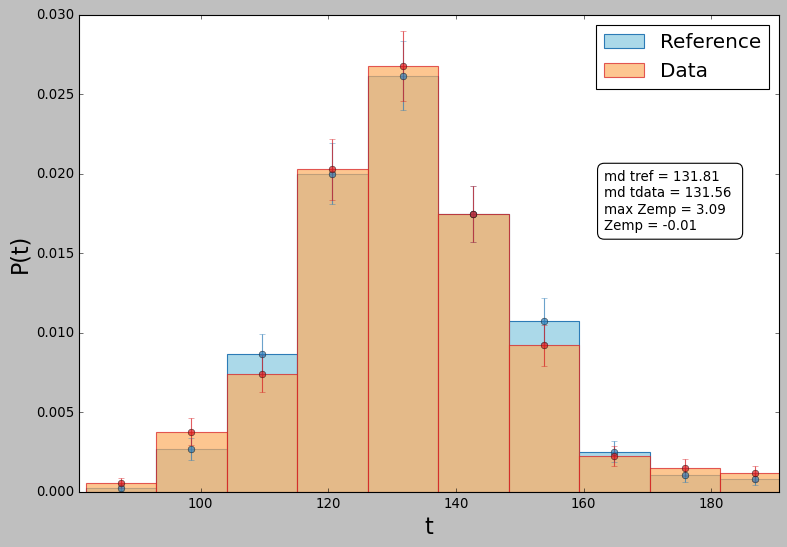

In [46]:
seed=1
pn = np.random.default_rng(seed=seed).choice(ref[:,0],size=len(ref[:,0]))
plot_ref_data(ref[:,0],pn)

In [20]:
def min_p(x):
    p_array = np.zeros_like(np.transpose(x))
    for idx1, col in enumerate(np.transpose(x)):
        p = []
        for idx2, el in enumerate(col):
            p.append(bootstrap_p(np.delete(col,idx2),el))
        p_array[idx1] = np.array(p)
        print(p)
    
    return p_array

In [41]:
idx = 0
ttrans = np.transpose(test_array)
col = ttrans[0]
rng = np.random.default_rng()
x_del = np.delete(test_array,col,axis=1)

IndexError: index 4 is out of bounds for axis 0 with size 3

In [34]:
col.transpose()

array([ 1,  4,  7, 10])

In [51]:
x = [ 1,  4,  7, 10]
for el in x:
    rng = np.random.default_rng()
    bootstrap = rng.choice(np.delete(x,idx),size=len(x)-1)
    print(bootstrap)
    print(np.mean(np.delete(col,idx)>=el))

[10 10  7]
1.0
[ 4 10 10]
1.0
[ 4 10 10]
0.6666666666666666
[10 10  4]
0.3333333333333333


In [49]:
bootstrap

array([ 7,  4, 10])

In [2]:
with open("./output/Ntoys100_NR200000_NB2000_NS90_nonres/t.txt", "r") as fp:
    # Load the dictionary from the file
    t_dict = json.load(fp)

In [3]:
t_array = []
for key in t_dict.keys():
    t_array.append(t_dict[key])
t_array = np.array(t_array).transpose()

In [4]:
np.save("./output/Ntoys100_NR200000_NB2000_NS90_nonres/t_array.npy",t_array)

In [61]:
fused_ref = fusion(t_array,1)

In [62]:
fused_ref.shape

(1000,)

In [17]:
return_best_chi2dof(t_array[:,0])

(112.5048877202664, 0.050396862457460834)

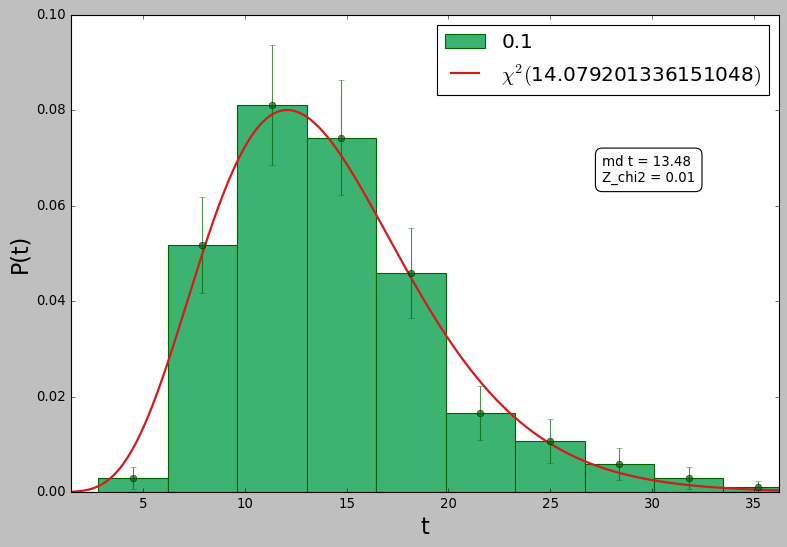

In [10]:
idx=3
plot_data(t_array[:,idx],label='0.1',dof=return_best_chi2dof(t_array[:,idx])[0])

In [8]:
from matplotlib import pyplot as plt

In [15]:
t_array[:,0].shape

(1000,)

In [3]:
with open("./output/Ntoys300_NR20000_NB2000_NS10_loc6.4_std0.16/t.txt", "r") as fp:
    # Load the dictionary from the file
    t_dict = json.load(fp)

In [4]:
t_array = []
for key in t_dict.keys():
    t_array.append(t_dict[key])
t_array = np.array(t_array).transpose()

In [5]:
np.save("./output/Ntoys300_NR20000_NB2000_NS10_loc6.4_std0.16/t_array.npy",t_array)

## nonres test 

In [4]:
from FLKutils_min import nonres_sig
import matplotlib.pyplot as plt

In [7]:
nonres_sample = nonres_sig(1000,0)

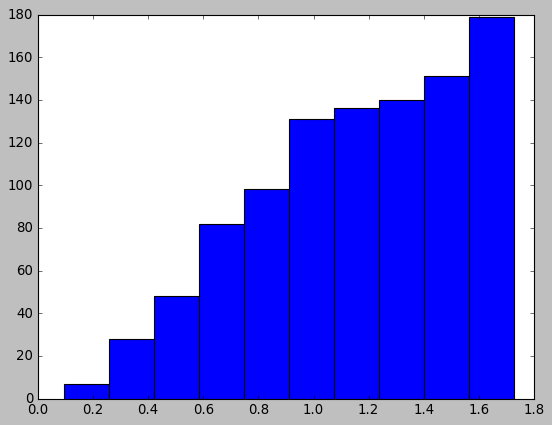

In [11]:
plt.hist(nonres_sample)
plt.show()

In [31]:
import numpy as np
import os
import h5py
#['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']
def BuildSample_DY_2(INPUT_PATH, rng, features=[], N_Events=-1, nfiles=20, shuffle=True):
    #random integer to select Zprime file between n files                                                                                                            
    u = np.arange(nfiles)#np.random.randint(100, size=100)                                                                                                           
    if shuffle: rng.shuffle(u)
    toy_label = INPUT_PATH.split("/")[-2]
    print(toy_label)
    HLF = np.array([])
    for u_i in u:
        if not os.path.exists(INPUT_PATH+toy_label+str(u_i+1)+".h5"): continue
        f    = h5py.File(INPUT_PATH+toy_label+str(u_i+1)+".h5", 'r')
        keys = list(f.keys())
        if u_i==u[0]:
            print('available features: ', keys)
        if len(keys)==0: continue #check whether the file is empty                                                                                                   
        cols = np.array([])
        if len(features): keys = features
        for i in range(len(keys)):
            feature = np.array(f.get(keys[i]))
            feature = np.expand_dims(feature, axis=1)
            if i==0: cols = feature
            else: cols = np.concatenate((cols, feature), axis=1)
        if shuffle: rng.shuffle(cols) #don't want to select always the same event first                                                                       \
                                                                                                                                                                     
        if HLF.shape[0]==0:
            HLF=cols
            i+=1
        else: HLF=np.concatenate((HLF, cols), axis=0)
        f.close()
        if N_Events>0 and HLF.shape[0]>=N_Events:
            HLF=HLF[:N_Events, : ]
            break
    print(HLF.shape)
    #return HLF[:, [4, 5, 1, 2, 0, 3]]                                                                                                                               
    return HLF

In [4]:
ref = BuildSample_DY(N_Events=20000, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=1234))
cut_mll = 60
cut_pt = 20
cut_eta = 2.4

mask_idx = np.where((ref[:, 4] <= cut_pt) | (ref[:, 5] <= cut_pt) | (np.abs(ref[:, 1]) > cut_eta) | (np.abs(ref[:, 2]) > cut_eta) | (ref[:, 3] <= cut_mll))[0]
masked_ref = np.delete(ref, mask_idx, axis=0)
# mean and std of reference data compute from the entire dataset - used to normalize
mean_ref = [3.05212537e+00, 4.59876795e-04, 3.66978211e-04, 4.67488118e+01,
       3.60544255e+01]
std_ref = [ 0.52342366,  1.24487457,  1.25051629, 15.86122412,  8.95046637]
for perc in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(perc)
    print(candidate_sigma(normalize(masked_ref[:,[0,1,2,4,5]],mean_ref,std_ref), perc=perc))

DiLepton_SM
(20000, 6)
1
0.313
5
0.567
10
0.761
25
1.182
50
1.773
75
2.47
90
3.152
95
3.546
99
4.205


In [35]:
print(ref.shape,
    masked_ref.shape)

(20000, 6) (18759, 6)


In [33]:
ref = BuildSample_DY_2('/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', np.random.default_rng(seed=1234), features=['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2'], N_Events=20000, nfiles=66, shuffle=True)
cut_mll = 60
cut_pt = 20
cut_eta = 2.4

mask = 1*(ref[:,3]>=cut_mll)*(np.abs(ref[:,1])<cut_eta)*(np.abs(ref[:,2])<cut_eta)*(ref[:,4]>=cut_pt)*(ref[:,5]>=cut_pt)
masked_ref = ref[mask>0]
# mean and std of reference data compute from the entire dataset - used to normalize
mean_ref = [3.05212537e+00, 4.59876795e-04, 3.66978211e-04, 4.67488118e+01,
       3.60544255e+01]
std_ref = [ 0.52342366,  1.24487457,  1.25051629, 15.86122412,  8.95046637]
for perc in [1, 5, 25, 50, 75, 90, 95, 99]:

    print(candidate_sigma(normalize(masked_ref[:,[0,1,2,4,5]],mean_ref,std_ref), perc=perc))

DiLepton_SM
available features:  ['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']
(20000, 6)
0.313
0.567
1.182
1.773
2.47
3.152
3.546
4.205


In [19]:
ref[mask>0]

array([[ 2.24106342e+00, -1.27310228e+00,  3.64202529e-01,
         9.06028268e+01,  4.22095032e+01,  2.95640774e+01],
       [ 2.90363580e+00,  5.98591149e-01, -2.19859743e+00,
         1.18139451e+02,  2.91574383e+01,  2.60104389e+01],
       [ 2.59955740e+00,  3.25456262e-01, -5.36577590e-02,
         8.95097868e+01,  6.56238174e+01,  3.16393261e+01],
       ...,
       [ 3.10783041e+00, -2.01773095e+00, -6.32607937e-02,
         9.00996197e+01,  3.13984871e+01,  2.81004925e+01],
       [ 3.10056466e+00, -5.28206348e-01,  4.87124741e-01,
         9.66036307e+01,  4.76336021e+01,  3.82584419e+01],
       [ 4.04011095e+00, -9.46760535e-01, -4.24076378e-01,
         9.15159541e+01,  5.39279404e+01,  4.40571671e+01]])

In [18]:
mask.shape

(20000,)